**STEP 0: Install & import libraries (Colab safe)**


In [23]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report


**STEP 1: Download & unzip the dataset**

In [24]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip UCI\ HAR\ Dataset.zip


--2025-12-18 17:15:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [     <=>            ]  58.17M  70.1MB/s    in 0.8s    

2025-12-18 17:15:43 (70.1 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.t

**STEP 2: Go inside dataset directory**

In [25]:
os.chdir("UCI HAR Dataset")
print(os.listdir())


['README.txt', 'features_info.txt', 'activity_labels.txt', '.DS_Store', 'test', 'train', 'features.txt']


**STEP 3: Load time-series sensor data (IMPORTANT)**

In [26]:
def load_X(path):
    files = sorted([
        f for f in os.listdir(path)
        if f.endswith('.txt') and not f.startswith('._')
    ])

    signals = []
    for file in files:
        file_path = os.path.join(path, file)
        signals.append(pd.read_csv(file_path, sep=r'\s+', header=None))

    return np.dstack(signals)


**STEP 4:Load Train & Test data**

In [27]:
X_train = load_X("train/Inertial Signals/")
X_test  = load_X("test/Inertial Signals/")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)


**STEP 5: Load labels**

In [28]:
y_train = pd.read_csv("train/y_train.txt", header=None)[0] - 1
y_test  = pd.read_csv("test/y_test.txt", header=None)[0] - 1

y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

print(y_train.shape, y_test.shape)


(7352, 6) (2947, 6)


**STEP 6: Activity names (for reports)**

In [29]:
labels = pd.read_csv("activity_labels.txt", sep=' ', header=None)
activity_names = labels[1].tolist()
print(activity_names)


['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']


**STEP 7: Define model input dimensions**

In [30]:
n_timesteps = X_train.shape[1]   # 128
n_features  = X_train.shape[2]   # 9
n_classes   = y_train.shape[1]   # 6

print(n_timesteps, n_features, n_classes)


128 9 6


**STEP 8: Build 2-Layer LSTM model**

In [31]:
model = Sequential()

# Input layer
model.add(Input(shape=(n_timesteps, n_features)))

# LSTM layer 1
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))

# LSTM layer 2
model.add(LSTM(64))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(n_classes, activation='softmax'))


**STEP 9: Compile model**

In [32]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 128, 64)        │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,358 (204.52 KB)

 Trainable params: 52,358 (204.52 KB)

 Non-trainable params: 0 (0.00 B)

**STEP 10: Train the model**

In [33]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4116 - loss: 1.4080 - val_accuracy: 0.6424 - val_loss: 0.9423
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6654 - loss: 0.8165 - val_accuracy: 0.8341 - val_loss: 0.5737
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8263 - loss: 0.5062 - val_accuracy: 0.8416 - val_loss: 0.5199
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9074 - loss: 0.2983 - val_accuracy: 0.8899 - val_loss: 0.4216
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9243 - loss: 0.2325 - val_accuracy: 0.8776 - val_loss: 0.3976
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9366 - loss: 0.1894 - val_accuracy: 0.9007 - val_loss: 0.4116
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9448 - loss: 0.1572 - val_accuracy: 0.9035 - val_loss: 0.4105
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9533 - loss: 0.1485 - val_accuracy: 0.8939 - v

**STEP 11: Evaluate on test set**

In [35]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 92.26%


**STEP 12: Predictions**

In [36]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


**STEP 13: Confusion Matrix**

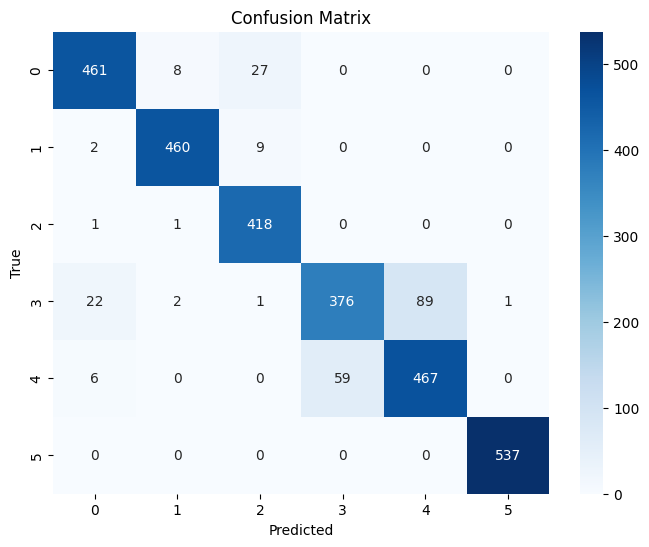

In [37]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


**STEP 14: F1-score & classification report**

In [38]:
print(classification_report(
    y_true,
    y_pred,
    target_names=activity_names
))


                    precision    recall  f1-score   support

           WALKING       0.94      0.93      0.93       496
  WALKING_UPSTAIRS       0.98      0.98      0.98       471
WALKING_DOWNSTAIRS       0.92      1.00      0.96       420
           SITTING       0.86      0.77      0.81       491
          STANDING       0.84      0.88      0.86       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



**STEP 15: Training curves**

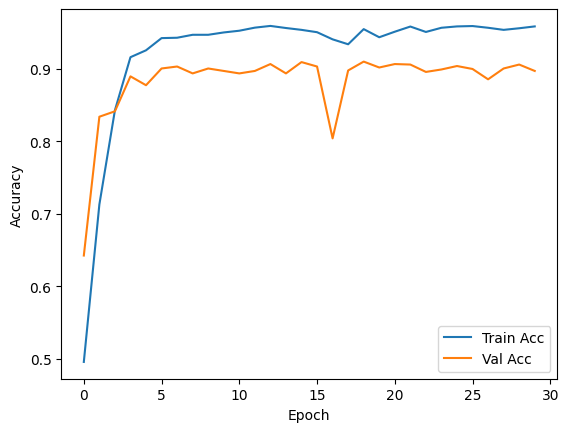

In [39]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**STEP 16: Save the model**

In [40]:
model.save("HAR_2Layer_LSTM.keras")
